In [1]:
#versão da Linguagem Python
from platform import python_version
print('Versão da linguagem Python usada no ambiente virtual desse projeto:', python_version())

Versão da linguagem Python usada no ambiente virtual desse projeto: 3.12.7


In [2]:
# --- 1. CONFIGURAÇÃO DO AMBIENTE ---

# Importação de bibliotecas padrão
import pandas as pd
import numpy as np
import os
import sys
from statsmodels.tsa.api import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Configurações de visualização para os gráficos
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (18, 7)
plt.rcParams['font.size'] = 12

In [3]:
# --- 2. CARGA E LIMPEZA DOS DADOS ---

# 2.1. Definição de Caminhos
base_dir = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
data_raw_path = os.path.join(base_dir, "data", "raw")
NOMES_ARQUIVOS = [
    "dados_serie_temporal_2014-01-01_a_2016-01-01.csv",
    "dados_serie_temporal_2016-01-01_a_2018-01-01.csv",
    "dados_serie_temporal_2018-01-01_a_2019-01-01.csv",
    "dados_serie_temporal_2019-01-01_a_2020-01-01.csv",
    "dados_serie_temporal_2020-01-01_a_2022-01-01.csv",
    "dados_serie_temporal_2022-01-01_a_2024-01-01.csv",
    "dsc.csv"
]

# 2.2. Leitura, Correção e Consolidação
lista_dataframes = []
for nome_arquivo in NOMES_ARQUIVOS:
    caminho_completo = os.path.join(data_raw_path, nome_arquivo)
    if os.path.exists(caminho_completo):
        df_temp = pd.read_csv(caminho_completo, sep=',', on_bad_lines='skip', engine='python', encoding='latin1', index_col=False)
        lista_dataframes.append(df_temp)
df_raw = pd.concat(lista_dataframes, ignore_index=True)

# 2.3. Limpeza
df_unico = df_raw.drop_duplicates(subset=['NUMERO'], keep='first').copy()
df_unico.loc[:, 'DATA_RECEBIMENTO'] = pd.to_datetime(df_unico['DATA_RECEBIMENTO'], errors='coerce')
df_unico.dropna(subset=['DATA_RECEBIMENTO'], inplace=True)
df_unico.sort_values(by='DATA_RECEBIMENTO', inplace=True)

print("✅ Carga e limpeza concluídas.")
print(f"Total de registros únicos e válidos: {len(df_unico)}")

# 2.4. Salvando o DataFrame consolidado e limpo
data_processed_path = os.path.join(base_dir, "data", "processed")
os.makedirs(data_processed_path, exist_ok=True) 

output_csv_path = os.path.join(data_processed_path, "dsc.csv")
df_unico.to_csv(output_csv_path, index=False, encoding='latin1')

print(f"📁 Arquivo salvo com sucesso em: {output_csv_path}")

C:\Users\mlzengo\AppData\Local\Temp\ipykernel_13608\1527771649.py:21: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df_temp = pd.read_csv(caminho_completo, sep=',', on_bad_lines='skip', engine='python', encoding='latin1', index_col=False)
C:\Users\mlzengo\AppData\Local\Temp\ipykernel_13608\1527771649.py:21: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df_temp = pd.read_csv(caminho_completo, sep=',', on_bad_lines='skip', engine='python', encoding='latin1', index_col=False)
C:\Users\mlzengo\AppData\Local\Temp\ipykernel_13608\1527771649.py:21: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df_temp = pd.read_csv(caminho_completo, sep=',', on_bad_lines='skip', engine='python', encoding='latin1', index_col=False)
C:\Users\mlzengo\AppData\Local\Temp\ipykernel_

✅ Carga e limpeza concluídas.
Total de registros únicos e válidos: 5678838
📁 Arquivo salvo com sucesso em: c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\data\processed\dsc.csv


In [4]:
df = pd.read_csv(r"C:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\data\processed\dsc.csv",sep=',', on_bad_lines='skip', engine='python', encoding='latin1', index_col=False)
df.head()
df.shape

(5678838, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5678838 entries, 0 to 5678837
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   NUMERO            object 
 1   DATA_RECEBIMENTO  object 
 2   PRIORIDADE        object 
 3   SEGREDO_JUSTICA   bool   
 4   SERVENTIA         object 
 5   COMARCA           object 
 6   CLASSE            float64
 7   ASSUNTOS          object 
 8   PROC_STATUS       object 
 9   AREA_ACAO         object 
 10  VALOR_CAUSA       float64
dtypes: bool(1), float64(2), object(8)
memory usage: 438.7+ MB


In [6]:
# --- 1. VISÃO GERAL DO DATASET ---

print("--- Informações Gerais do DataFrame ---")

print("\n--- Verificação de Valores Nulos ---")
# Contando valores nulos por coluna e mostrando em ordem decrescente
missing_values = df_unico.isnull().sum().sort_values(ascending=False)
print(missing_values[missing_values > 0]) # Mostra apenas colunas com valores nulos

--- Informações Gerais do DataFrame ---

--- Verificação de Valores Nulos ---
VALOR_CAUSA    876598
CLASSE          37121
ASSUNTOS          501
dtype: int64



--- Análise da Coluna: 'COMARCA' ---
Número de categorias únicas: 119
As 15 categorias principais representam 69.02% de todos os casos.


C:\Users\mlzengo\AppData\Local\Temp\ipykernel_13608\2908973393.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=contagem.head(top_n).index, y=contagem.head(top_n).values, palette='viridis')


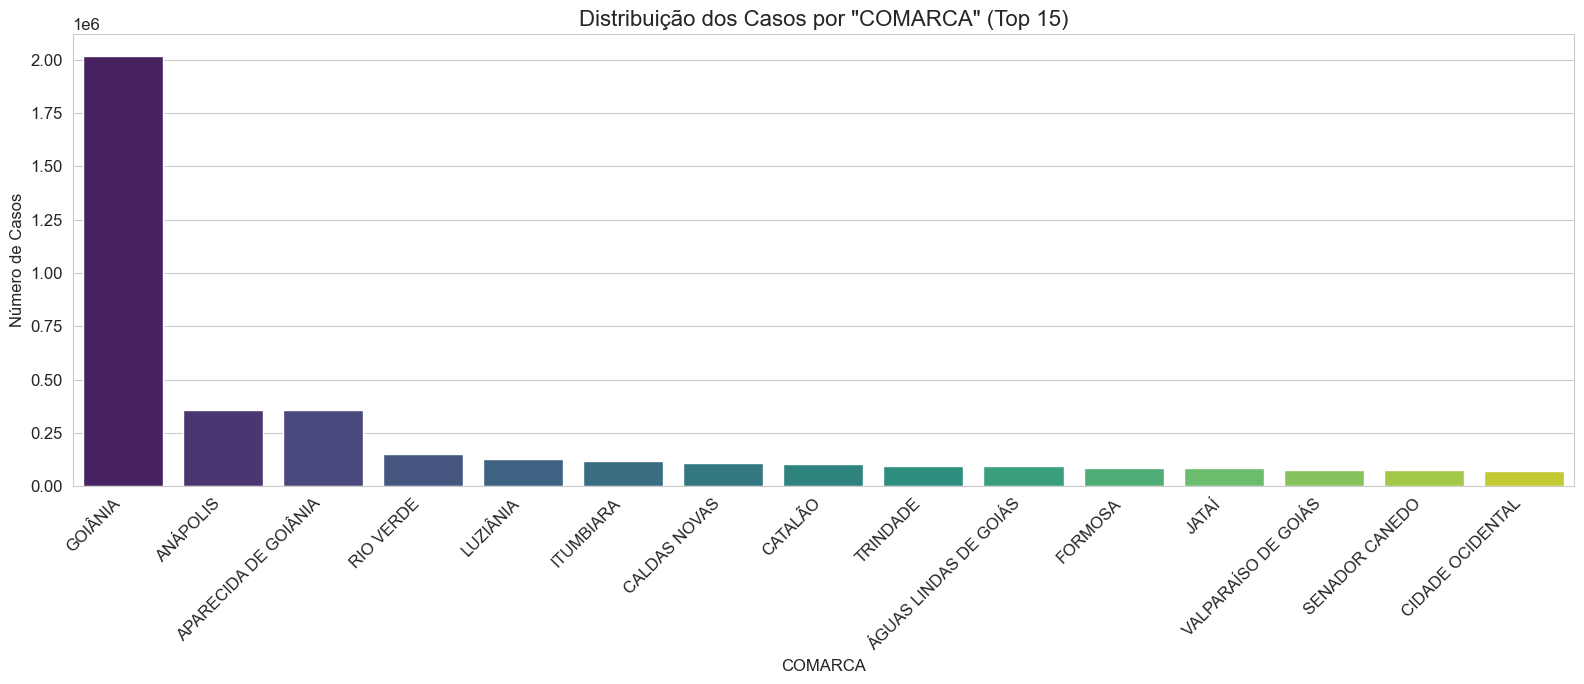

In [7]:
# --- 2.1 ANÁLISE DOS SEGMENTOS CATEGÓRICOS ---

def analisar_segmento(df, coluna, top_n=15):
    """
    Função para analisar e visualizar a distribuição de uma coluna categórica.
    """
    print(f"\n--- Análise da Coluna: '{coluna}' ---")
    
    # Quantidade de valores únicos
    num_unicos = df[coluna].nunique()
    print(f"Número de categorias únicas: {num_unicos}")
    
    # Contagem das categorias mais frequentes
    contagem = df[coluna].value_counts()
    
    # Porcentagem do total representada pelas Top N categorias
    porc_top_n = (contagem.head(top_n).sum() / len(df)) * 100
    print(f"As {top_n} categorias principais representam {porc_top_n:.2f}% de todos os casos.")
    
    # Visualização
    plt.figure(figsize=(16, 7))
    sns.barplot(x=contagem.head(top_n).index, y=contagem.head(top_n).values, palette='viridis')
    plt.title(f'Distribuição dos Casos por "{coluna}" (Top {top_n})', fontsize=16)
    plt.ylabel('Número de Casos')
    plt.xlabel(coluna)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return contagem

# Aplicando a função para as colunas de interesse
contagem_comarca = analisar_segmento(df_unico, 'COMARCA')

In [11]:
# Salvar um arquivo CSV para cada categoria em 'AREA_ACAO'
for area in df_unico['AREA_ACAO'].dropna().unique():
    df_area = df_unico[df_unico['AREA_ACAO'] == area]
    output_path = os.path.join(data_processed_path, f"dados_area_{area.lower()}.csv")
    df_area.to_csv(output_path, index=False, encoding='utf-8')
    print(f"Arquivo salvo para área '{area}': {output_path}")

Arquivo salvo para área 'Cível': c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\data\processed\dados_area_cível.csv
Arquivo salvo para área 'Criminal': c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\data\processed\dados_area_criminal.csv


In [14]:
# --- CRIAR E SALVAR DATASETS POR AREA_ACAO ---

# Assumindo que o DataFrame 'df_unico' já está carregado e limpo.
print("Iniciando a segmentação por Área de Ação: Cível e Criminal...")

# 1. Limpeza e Padronização da Coluna 'AREA_ACAO'
#    - Convertemos para string para lidar com possíveis valores nulos ou outros tipos.
#    - .str.strip() remove espaços em branco no início e no fim.
#    - .str.upper() converte para maiúsculas (ex: 'cível' -> 'CÍVEL').
try:
    df_unico['AREA_ACAO'] = df_unico['AREA_ACAO'].astype(str).str.strip().str.upper()
    print("✅ Coluna 'AREA_ACAO' limpa e padronizada.")
except Exception as e:
    print(f"⚠️ Erro ao tentar limpar a coluna 'AREA_ACAO': {e}")


# --- Segmento Cível ---
print("\n--- Processando Área Cível ---")
# 2. Filtrar o DataFrame para conter apenas registros da área 'CÍVEL'
df_civel = df_unico[df_unico['AREA_ACAO'] == 'CÍVEL'].copy()
total_registros_civel = len(df_civel)
print(f"Total de registros encontrados para a área Cível: {total_registros_civel}")

# 3. Salvar o arquivo CSV para a área Cível
if total_registros_civel > 0:
    output_dir = os.path.join(base_dir, "data", "processed")
    os.makedirs(output_dir, exist_ok=True)
    caminho_saida_civel = os.path.join(output_dir, "casos_area_civel.csv")
    
    df_civel.to_csv(caminho_saida_civel, index=False, encoding='utf-8')
    print(f"✅ Arquivo Cível salvo com sucesso em: {caminho_saida_civel}")
else:
    print("⚠️ Nenhum registro encontrado para a área Cível.")


# --- Segmento Criminal ---
print("\n--- Processando Área Criminal ---")
# 4. Filtrar o DataFrame para conter apenas registros da área 'CRIMINAL'
df_criminal = df_unico[df_unico['AREA_ACAO'] == 'CRIMINAL'].copy()
total_registros_criminal = len(df_criminal)
print(f"Total de registros encontrados para a área Criminal: {total_registros_criminal}")

# 5. Salvar o arquivo CSV para a área Criminal
if total_registros_criminal > 0:
    output_dir = os.path.join(base_dir, "data", "processed")
    os.makedirs(output_dir, exist_ok=True)
    caminho_saida_criminal = os.path.join(output_dir, "casos_area_criminal.csv")
    
    df_criminal.to_csv(caminho_saida_criminal, index=False, encoding='utf-8')
    print(f"✅ Arquivo Criminal salvo com sucesso em: {caminho_saida_criminal}")
else:
    print("⚠️ Nenhum registro encontrado para a área Criminal.")

Iniciando a segmentação por Área de Ação: Cível e Criminal...
✅ Coluna 'AREA_ACAO' limpa e padronizada.

--- Processando Área Cível ---
Total de registros encontrados para a área Cível: 4604536
✅ Arquivo Cível salvo com sucesso em: c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\data\processed\casos_area_civel.csv

--- Processando Área Criminal ---
Total de registros encontrados para a área Criminal: 1074302
✅ Arquivo Criminal salvo com sucesso em: c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\data\processed\casos_area_criminal.csv


In [38]:
# --- 3. CRIAÇÃO DA SÉRIE TEMPORAL DIÁRIA ---

# Agregar para o nível diário
df_temporal = df_unico.set_index('DATA_RECEBIMENTO')
serie_diaria = df_temporal['NUMERO'].resample('D').size()
ts_df = serie_diaria.to_frame(name='NOVOS_CASOS')
ts_df = ts_df.asfreq('D', fill_value=0)

print("Série temporal diária criada com sucesso.")
ts_df.head()

Série temporal diária criada com sucesso.


c:\Users\mlzengo\Documents\TJGO\II SEMESTRE\forecast_case\.venv\Lib\site-packages\pandas\core\indexes\base.py:7654: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,NOVOS_CASOS
DATA_RECEBIMENTO,
2014-01-01,12
2014-01-02,82
2014-01-03,49
2014-01-04,1014
2014-01-05,174


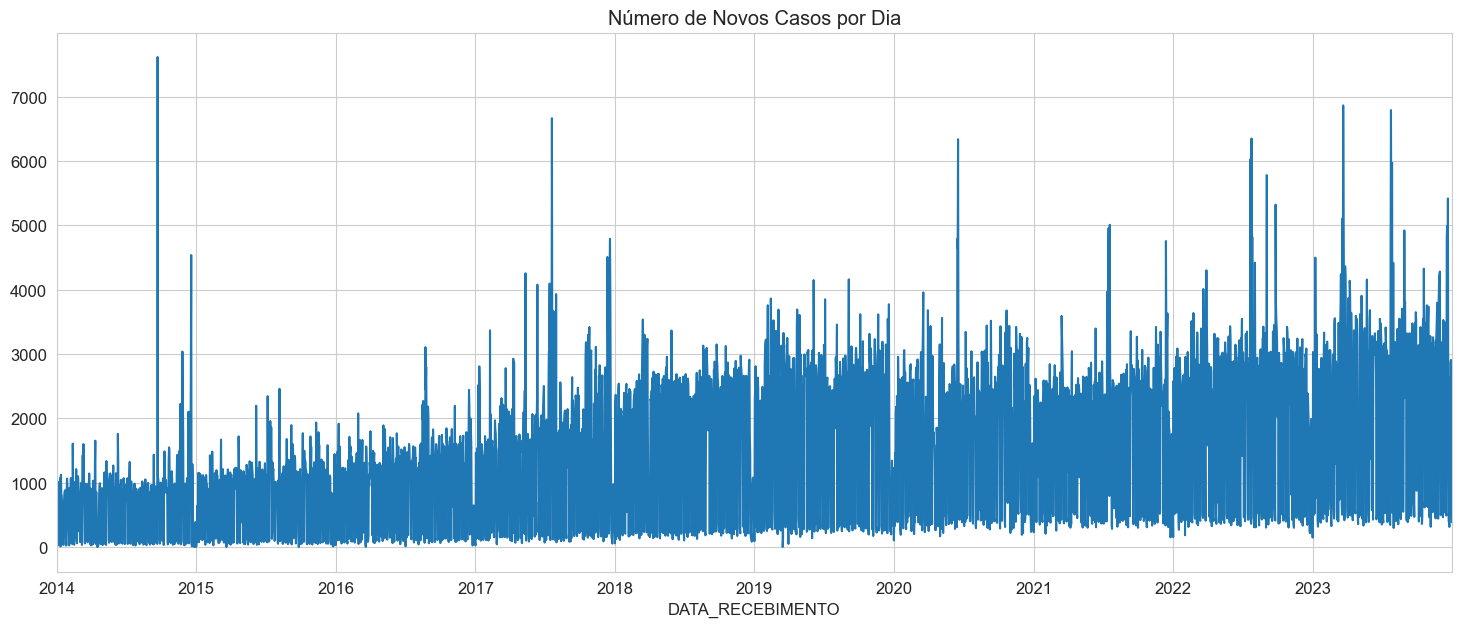

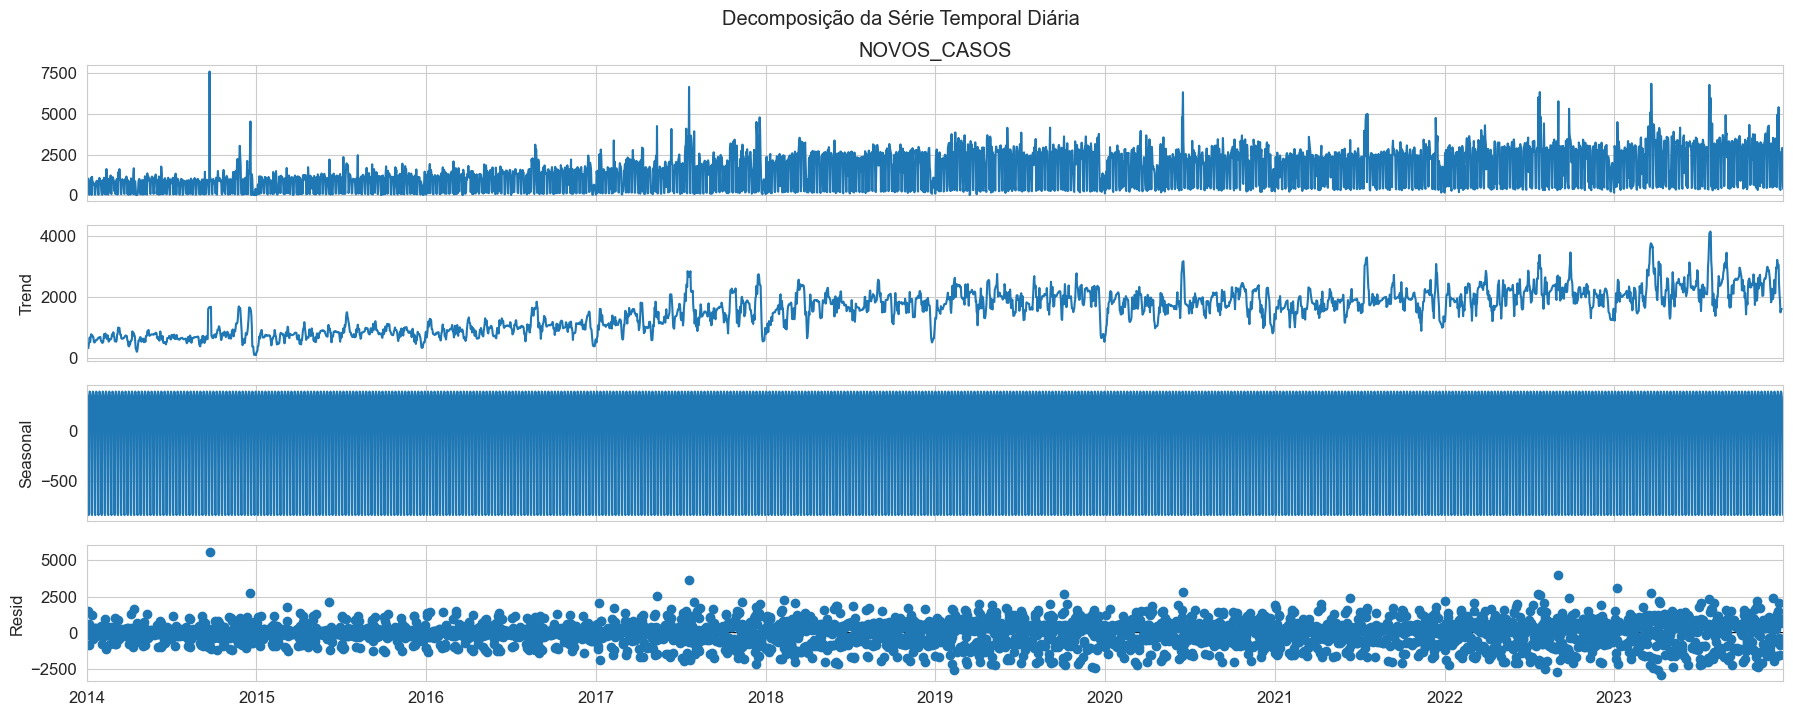

In [39]:
# --- 4.1. VISUALIZAÇÃO E DECOMPOSIÇÃO (DIÁRIA) ---

ts_df['NOVOS_CASOS'].plot(title='Número de Novos Casos por Dia')
plt.show()

decomposicao_diaria = seasonal_decompose(ts_df['NOVOS_CASOS'], model='additive', period=7)
fig = decomposicao_diaria.plot()
plt.suptitle('Decomposição da Série Temporal Diária', y=1.02)
plt.show()

--- Teste ADF na Série Original ---
p-valor: 0.015461122274108967
Conclusão: A série é ESTACIONÁRIA.

--- Gráficos de Autocorrelação (Série Original) ---


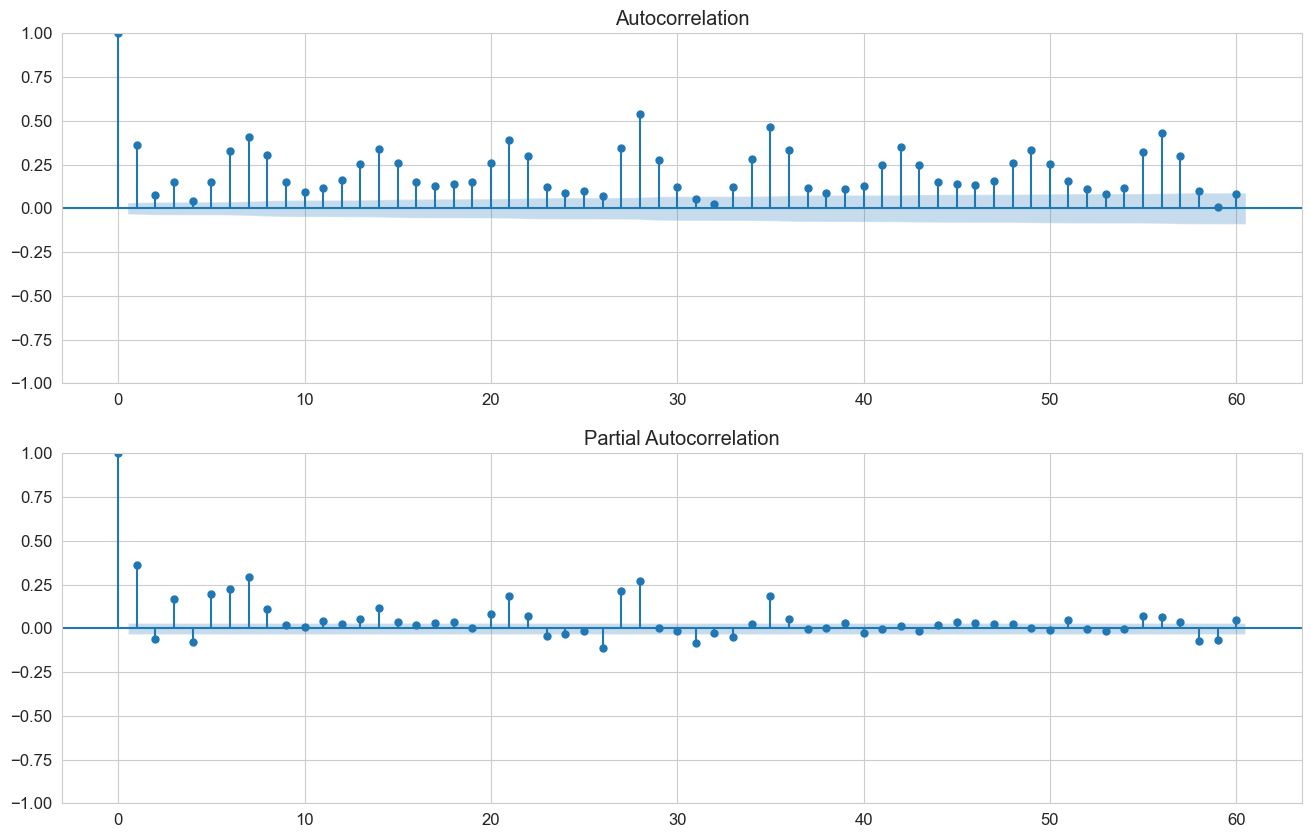

In [40]:
# --- 4.2. ANÁLISE DE ESTACIONARIEDADE E AUTOCORRELAÇÃO (SÉRIE ORIGINAL) ---

# Teste ADF na série original
print("--- Teste ADF na Série Original ---")
result_adf_orig = adfuller(ts_df['NOVOS_CASOS'])
print(f'p-valor: {result_adf_orig[1]}')
if result_adf_orig[1] > 0.05:
    print("Conclusão: A série é NÃO-ESTACIONÁRIA.")
else:
    print("Conclusão: A série é ESTACIONÁRIA.")

# Gráficos de Autocorrelação (ACF e PACF)
print("\n--- Gráficos de Autocorrelação (Série Original) ---")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))
plot_acf(ts_df['NOVOS_CASOS'], ax=ax1, lags=60)
plot_pacf(ts_df['NOVOS_CASOS'], ax=ax2, lags=60)
plt.show()

--- Teste ADF na Série Diferenciada ---
p-valor: 0.0
Conclusão: A série diferenciada é agora ESTACIONÁRIA.


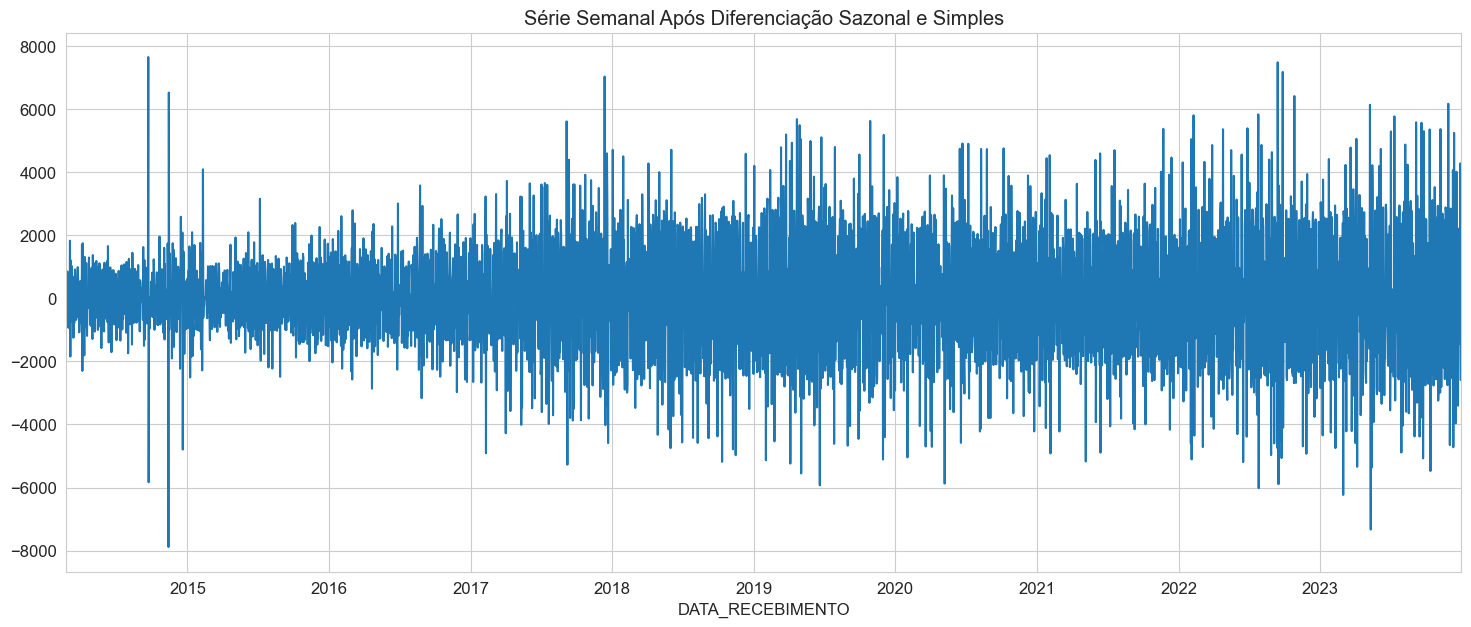

In [41]:
# --- 5.1. DIFERENCIAÇÃO E VERIFICAÇÃO ---

# Aplicando diferenciação sazonal (lag=52 para semanas) e simples (lag=1)
ts_df['casos_diff'] = ts_df['NOVOS_CASOS'].diff(52).diff()
ts_diff_final = ts_df['casos_diff'].dropna()

# Verificando a estacionariedade da série diferenciada
print("--- Teste ADF na Série Diferenciada ---")
result_adf_diff = adfuller(ts_diff_final)
print(f'p-valor: {result_adf_diff[1]}')
if result_adf_diff[1] <= 0.05:
    print("Conclusão: A série diferenciada é agora ESTACIONÁRIA.")
else:
    print("Conclusão: A série ainda NÃO é ESTACIONÁRIA. Pode ser necessário ajustar a diferenciação.")

# Visualizando a série diferenciada 
ts_diff_final.plot(title='Série Semanal Após Diferenciação Sazonal e Simples')
plt.show()


--- Gráficos de Autocorrelação (Série Diferenciada) ---


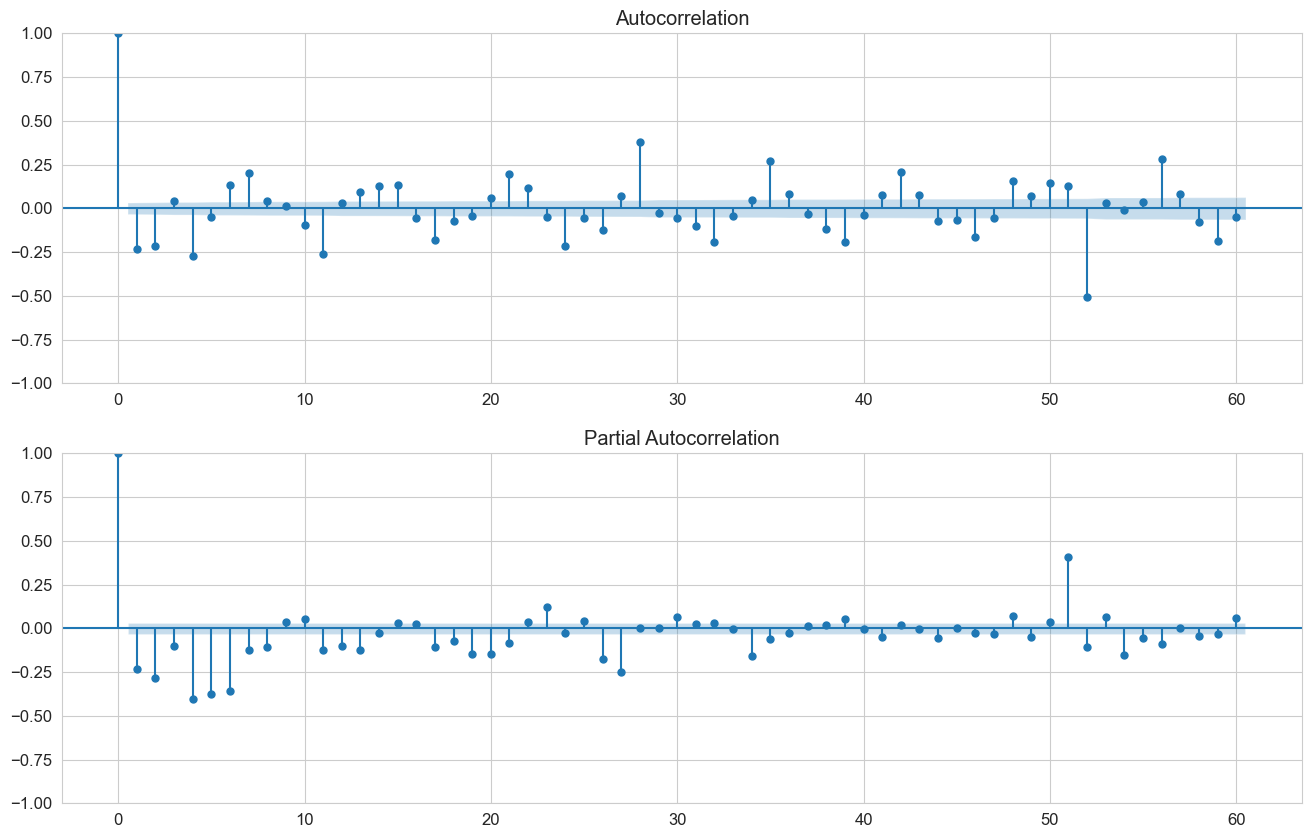

In [42]:
# --- 5.2. ANÁLISE DE AUTOCORRELAÇÃO (SÉRIE DIFERENCIADA) ---

print("\n--- Gráficos de Autocorrelação (Série Diferenciada) ---")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))
plot_acf(ts_diff_final, ax=ax1, lags=60)
plot_pacf(ts_diff_final, ax=ax2, lags=60)
plt.show()

In [43]:
# --- 6.1. DIVISÃO DOS DADOS EM TREINO E TESTE ---

if 'ts_df' in locals() and isinstance(ts_df, pd.DataFrame) and not ts_df.empty:
    treino = ts_df.iloc[:-52]
    teste = ts_df.iloc[-52:]

    print("Divisão dos dados concluída:")
    print(f"Período de Treino: {treino.index.min().strftime('%Y-%m-%d')} a {treino.index.max().strftime('%Y-%m-%d')}")
    print(f"Período de Teste:  {teste.index.min().strftime('%Y-%m-%d')} a {teste.index.max().strftime('%Y-%m-%d')}")
else:
    print("ERRO: O DataFrame 'ts_df' não foi encontrado ou está vazio. Por favor, execute as células anteriores.")

Divisão dos dados concluída:
Período de Treino: 2014-01-01 a 2023-11-09
Período de Teste:  2023-11-10 a 2023-12-31


In [44]:
# --- 6.2. TREINAMENTO DO MODELO SARIMA ---

# Verificando se o conjunto de treino existe antes de prosseguir
if 'treino' in locals():
    print("Iniciando o treinamento do modelo SARIMA(0, 1, 1)x(1, 1, 1, 52)...")
    
    # Instanciando o modelo com os parâmetros definidos'
    modelo = SARIMAX(treino['NOVOS_CASOS'],
                     order=(0, 1, 1),
                     seasonal_order=(1, 1, 1, 52),
                     enforce_stationarity=False,
                     enforce_invertibility=False)

    resultado = modelo.fit(disp=False) 

    print("\n Treinamento concluído!")
    
    # Imprimindo um resumo dos resultados do modelo
    print(resultado.summary())
else:
    print("ERRO: O conjunto de treino 'treino' não foi encontrado.")

Iniciando o treinamento do modelo SARIMA(0, 1, 1)x(1, 1, 1, 52)...

 Treinamento concluído!
                                     SARIMAX Results                                      
Dep. Variable:                        NOVOS_CASOS   No. Observations:                 3600
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 52)   Log Likelihood              -29278.972
Date:                            Wed, 06 Aug 2025   AIC                          58565.944
Time:                                    15:05:10   BIC                          58590.578
Sample:                                01-01-2014   HQIC                         58574.736
                                     - 11-09-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0097 